In [1]:
import pandas as pd
import json

In [2]:
# goals: 
# 1. evaluate centrality
# 2. cluster narrative function
# 3. 

In [3]:
ls ../data/v2_narr_parsed/

v2_test_set_narr.json   v2_train_set_narr.json


In [4]:
narr_train = json.load(open('../data/v2_narr_parsed/v2_train_set_narr.json'))
narr_test = json.load(open('../data/v2_narr_parsed/v2_test_set_narr.json'))
narr_df = pd.concat([
    pd.DataFrame(narr_train), pd.DataFrame(narr_test)
])
source_narr_df = narr_df.explode('sources').dropna().reset_index(drop=True)
source_narr_df = pd.concat([
    source_narr_df[['url']],
    source_narr_df['sources'].pipe(lambda s: pd.DataFrame(s.tolist()))
], axis=1)


## processing

persp_to_keep = set(['Informative', 'Authoritative', 'Neutral', 'Supportive', 'Against'])
source_narr_df['Perspective'] = (
    source_narr_df['Perspective']
         .apply(lambda x: {'Skeptical': 'Against', 'Defensive': 'Supportive'}.get(x, x))
         .apply(lambda x: x if x in persp_to_keep else 'Other')
)

cent_to_keep = set(['High', 'Medium', 'Low'])
source_narr_df['Centrality'] = source_narr_df['Centrality'].apply(lambda x: x if x in cent_to_keep else 'Low')

# Centrality Position in Document

In [147]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
data_dir = '../data'
data_dir = '../../../bloomberg-research/press-releases/data/s_p_500_backlinks'
batches = pd.read_json(f'{data_dir}/full-source-scored-data.jsonl', lines=True, chunksize=10_000)

In [148]:
orig_source_df_batches = []
for batch in tqdm(batches):
    batch_to_keep = batch.loc[lambda df: df['article_url'].isin(source_narr_df['url'])]
    orig_source_df_batches.append(batch_to_keep)
orig_source_df = pd.concat(orig_source_df_batches)

0it [00:00, ?it/s]

In [179]:
orig_source_df_exp = (
    orig_source_df[['article_url', 'attributions', 'quote_type']]
        .explode(['attributions', 'quote_type'])
        .reset_index(drop=True)
)

In [186]:
source_proportions = (
    orig_source_df_exp
         .value_counts(['article_url', 'attributions'])
         .reset_index()
         .pipe(lambda df: df.merge(df.groupby('article_url')['count'].sum().to_frame('overall_counts'), right_index=True, left_on='article_url'))
         .assign(prop=lambda df: df['count'] / df['overall_counts'])
         .drop(columns=['count', 'overall_counts'])
)

In [209]:
orig_source_df_exp['article_sent_idx'] = orig_source_df_exp.groupby('article_url').cumcount()

source_min_sent_props = (orig_source_df_exp
 .pipe(lambda df: 
    df.groupby(['article_url', 'attributions'])['article_sent_idx'].min().to_frame('min_sent_idx').reset_index()
            .merge(df.value_counts('article_url').to_frame('total_sents').reset_index()))
 .assign(min_sent_prop = lambda df: df['min_sent_idx'] / df['total_sents'])
 .drop(columns=['min_sent_idx', 'total_sents'])
)

In [215]:
source_min_sent_props.merge(source_proportions)

,article_url,attributions,min_sent_prop,prop
0,1059sunnyfm.cbslocal.com/tag/taylor-swift/feed/,CBS,0.053097,0.008850
1,1059sunnyfm.cbslocal.com/tag/taylor-swift/feed/,Carly Simon,0.141593,0.008850
2,1059sunnyfm.cbslocal.com/tag/taylor-swift/feed/,Dave Grohl vs. Win Butler vs. Gwen Stefani,0.238938,0.008850
3,1059sunnyfm.cbslocal.com/tag/taylor-swift/feed/,Ed Sheeran,0.796460,0.008850
4,1059sunnyfm.cbslocal.com/tag/taylor-swift/feed/,Foo Fighters,0.256637,0.008850
...,...,...,...,...
649918,yourvoicematters.news.blog/2019/06/07/the-cost...,director of the Rosenberg Railroad Museum,0.409091,0.090909
649919,yourvoicematters.news.blog/2019/06/07/the-cost...,journalist,0.000000,0.500000
649920,yourvoicematters.news.blog/2019/06/07/the-cost...,journalist passive-voice The noise was so over...,0.272727,0.090909
649921,yourvoicematters.news.blog/2019/06/07/the-cost...,journalist passive-voice The noise was so over...,0.727273,0.045455


In [219]:
source_narr_df_with_metrics = (
    source_narr_df
         [['url', 'Original name', 'Perspective', 'Centrality']]
         .explode('Original name')
         .merge(
             source_min_sent_props.merge(source_proportions),
             left_on=['url', 'Original name'],
             right_on=['article_url', 'attributions']
         )
         .drop(columns=['url', 'Original name'])
)

In [223]:
import seaborn as sns
import matplotlib.pyplot as plt

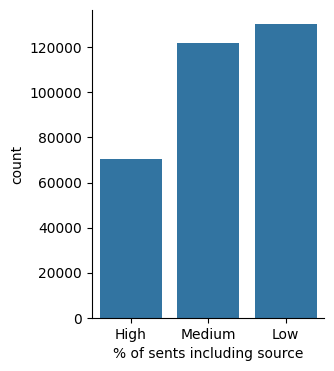

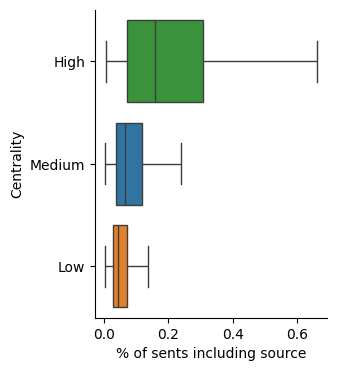

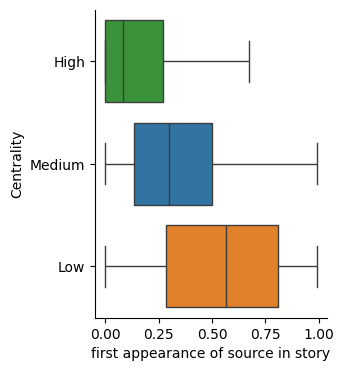

In [255]:
f, ax = plt.subplots( 1, 1, figsize=(3, 4))
sns.barplot(
    source_narr_df_with_metrics['Centrality'].value_counts(), 
    order=col_order,
    ax=ax
)
ax.set_xlabel('% of sents including source')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#[col_order].plot(kind='bar', figsize=(3,4))

col_order = ['High', 'Medium', 'Low']
f, ax = plt.subplots( 1, 1, figsize=(3, 4))
ax = sns.boxplot(
    source_narr_df_with_metrics, 
    x='prop',
    y='Centrality', hue='Centrality', order=col_order,
    showfliers=False,
    ax=ax
)
ax.set_xlabel('% of sents including source')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

f, ax = plt.subplots( 1, 1, figsize=(3, 4))
ax = sns.boxplot(
    source_narr_df_with_metrics, 
    x='min_sent_prop',
    y='Centrality', hue='Centrality', order=col_order,
    showfliers=False,
    ax=ax
)
ax.set_xlabel('first appearance of source in story')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [233]:
source_narr_df_with_metrics.head(2)

,Perspective,Centrality,article_url,attributions,min_sent_prop,prop
0,Against,Medium,www.fox61.com/article/news/nation-world/steps-...,Jonathan S. Weissman,0.393939,0.121212
1,Informative,Low,www.fox61.com/article/news/nation-world/steps-...,The New York Times,0.636364,0.030303


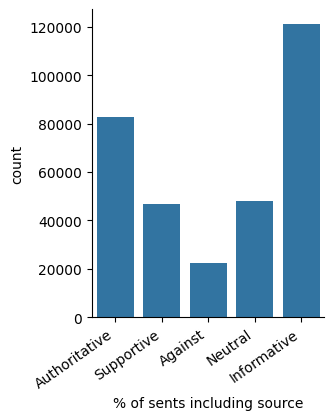

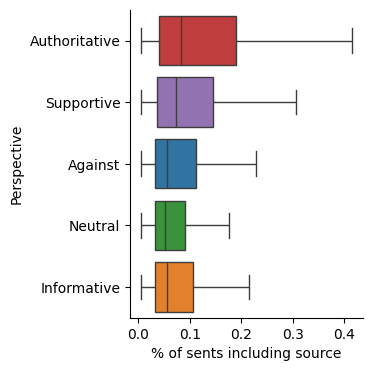

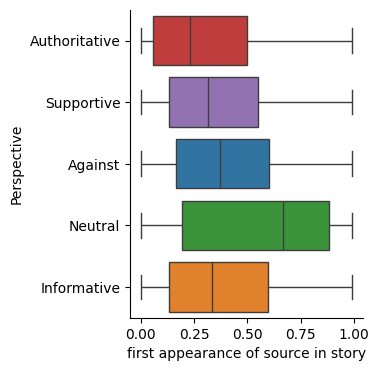

In [259]:
col_order = ['Authoritative', 'Supportive', 'Against', 'Neutral', 'Informative']

f, ax = plt.subplots( 1, 1, figsize=(3, 4))
sns.barplot(
    source_narr_df_with_metrics['Perspective'].value_counts(), 
    order=col_order,
    ax=ax
)
ax.set_xlabel('% of sents including source')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(rotation=35, horizontalalignment='right')

f, ax = plt.subplots( 1, 1, figsize=(3,4))
ax = sns.boxplot(
    source_narr_df_with_metrics, 
    x='prop',
    y='Perspective', hue='Perspective', order=col_order,
    showfliers=False,
    ax=ax
)
ax.set_xlabel('% of sents including source')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

f, ax = plt.subplots( 1, 1, figsize=(3,4))
ax = sns.boxplot(
    source_narr_df_with_metrics, 
    x='min_sent_prop',
    y='Perspective', hue='Perspective', order=col_order,
    showfliers=False,
    ax=ax
)
ax.set_xlabel('first appearance of source in story')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [169]:
source_narr_df['Centrality'].value_counts()#['Perspective'].value_counts()

Centrality
Low       144027
Medium    127307
High       72594
Name: count, dtype: int64

In [170]:
source_narr_df['Perspective'].value_counts()

Perspective
Informative      129649
Authoritative     85882
Neutral           54767
Supportive        49379
Against           23592
Other               659
Name: count, dtype: int64